In [1]:
# ! pip install pareto

In [2]:
from besos.parameters import wwr, RangeParameter, FieldSelector, FilterSelector, GenericSelector, Parameter, expand_plist
from besos.parameters import RangeParameter, CategoryParameter, expand_plist
from besos.objectives import MeterReader, VariableReader, time_series_values

from besos import eppy_funcs as ef
from besos import eplus_funcs as epf
from besos.eplus_funcs import print_available_outputs, get_ep_path, get_idf_version
import besos.sampling as sampling
from besos.evaluator import EvaluatorEP, EvaluatorGeneric
from besos.problem import EPProblem, Problem

import sqlite3
import copy
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import numpy as np

import matplotlib.pyplot as plt

from besos.optimizer import NSGAII

from platypus.evaluator import MapEvaluator

import plotly.express as px
import plotly.graph_objects as go

import pareto

In [3]:
opt_results=pd.read_pickle('opt_results.p')
average_inputs=pd.read_pickle('average_inputs.p')
average_results=pd.read_pickle('average_results.p')
average_outputs=average_inputs.join(average_results)
average_inputs_design=pd.read_pickle('average_inputs_design.p')
average_results_design=pd.read_pickle('average_design_results.p')
average_outputs_design=average_inputs_design.join(average_results_design)
opt_inputs=pd.read_pickle('opt_inputs.p')
opt_outputs=pd.read_pickle('opt_outputs.p')
opt_outputs=opt_inputs.join(opt_outputs)
average_opt_inputs=pd.read_pickle('average_opt_inputs.p')
average_opt_outputs=pd.read_pickle('average_opt_outputs.p')
average_opt_outputs=average_opt_inputs.join(average_opt_outputs)


In [4]:
opt_outputs.sort_values('Energy [ekWh/m2]',inplace=True)
opt_outputs['Average Minimum Box Position']=opt_outputs.loc[:,'Bottom Core VAV Reheat Minimum Box Position':'Top West VAV Reheat Minimum Box Position'].mean(axis=1)

In [5]:
average_opt_outputs['Average Minimum Box Position']=average_opt_outputs.loc[:,'Bottom Core VAV Reheat Minimum Box Position':'Top West VAV Reheat Minimum Box Position'].mean(axis=1)

In [6]:
average_outputs_design['Average Minimum Box Position']=average_outputs_design['Bottom Core VAV Reheat Minimum Box Position']
average_outputs_design=average_outputs_design.loc[:,'Minimum OA Damper Percent Open':]
average_outputs_design.insert(0, 'Average Minimum Box Position', average_outputs_design.pop('Average Minimum Box Position'))
average_outputs['Average Minimum Box Position']=average_outputs['Bottom Core VAV Reheat Minimum Box Position']
average_outputs=average_outputs.loc[:,'Minimum OA Damper Percent Open':]
average_outputs.insert(0, 'Average Minimum Box Position', average_outputs.pop('Average Minimum Box Position'))

## Part 1
Does quantifying ventilation performance using hourly dynamic simulations provide information that is useful beyond the standard design-day calculation procedure?


- Create a baseline by setting all to 30%, and then performing the ASHRAE 62 methodology. Include the energy prediction.
- Calculate the amount of underventilation at the baseline
- Compare to a revised baseline with +/- 10% damper position and +/- 10% minimum box position.
- For a number of terminal box positions, quantify the energy and underventilation amounts if designed at static conditions.

In [7]:
baseline=average_outputs_design.iloc[2]
baseline

Average Minimum Box Position                          0.200000
Minimum OA Damper Percent Open                        0.458999
Energy [ekWh/m2]                                    125.022253
Underventilation [%] 1.0                              2.808185
Underventilation [%] 1.1                              3.864611
Underventilation [%] 1.2                              5.000249
Underventilation [%] 1.3                              6.253123
Underventilation [%] 1.4                              7.577710
Underventilation [%] 1.5                              8.922518
Underventilation [%] 1.6                             10.270570
Underventilation [%] 1.7000000000000002              11.658680
Underventilation [%] 1.8                             13.120961
Underventilation [%] 1.9                             14.639414
Underventilation [%] 2.0                             16.179352
Design Damper Position [% OA] 1.0                    45.900406
Design Damper Position [% OA] 1.1                    54

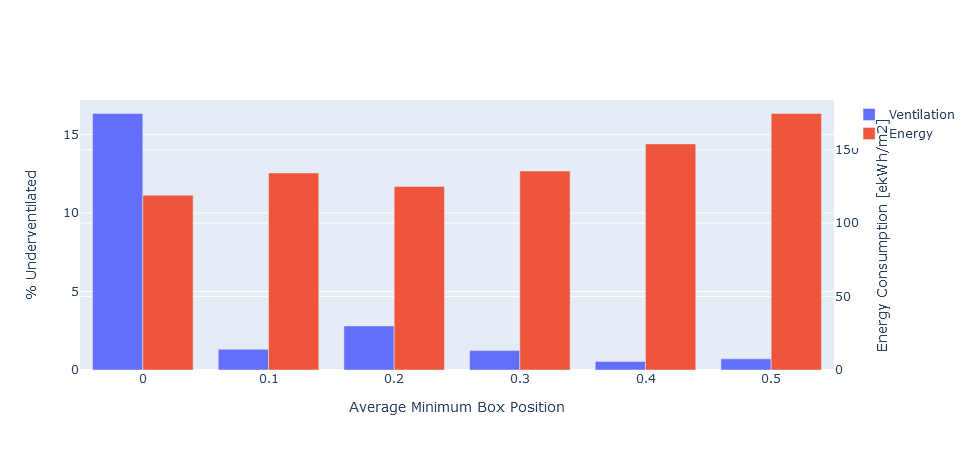

In [8]:
fig = go.Figure([go.Bar(x=average_outputs_design['Average Minimum Box Position'],
                        y=average_outputs_design['Underventilation [%] 1.0'],
                        yaxis='y1',
                        offsetgroup=1,
                        name='Ventilation'
                       ),
                go.Bar(x=average_outputs_design['Average Minimum Box Position'],
                        y=average_outputs_design['Energy [ekWh/m2]'],
                        yaxis='y2',
                      offsetgroup=2,
                        name='Energy')],
               layout={
        'yaxis': {'title': '% Underventilated'},
        'yaxis2': {'title': 'Energy Consumption [ekWh/m2]', 'overlaying': 'y', 'side': 'right'},
        'xaxis': {'title': 'Average Minimum Box Position'}
    })
fig.update_layout(barmode='group',showlegend=True)

fig.show()

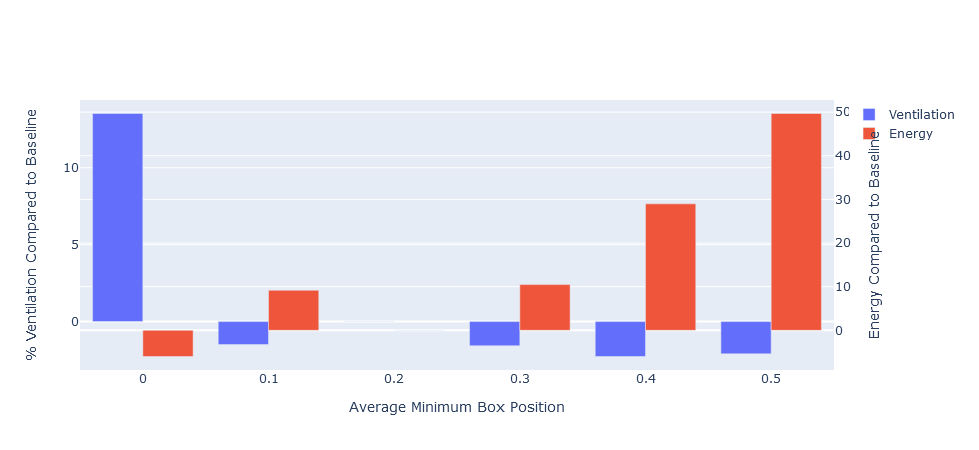

In [9]:
data=average_outputs_design.copy(deep=True)
data.loc[:,'Energy [ekWh/m2]':]=(data.loc[:,'Energy [ekWh/m2]':]-data.loc[2,'Energy [ekWh/m2]':])

fig = go.Figure([go.Bar(x=data['Average Minimum Box Position'],
                        y=data['Underventilation [%] 1.0'],
                        name='Ventilation',
                        yaxis='y',
                      offsetgroup=1
                       ),
                go.Bar(x=data['Average Minimum Box Position'],
                        y=data['Energy [ekWh/m2]'],
                        name='Energy',
                        yaxis='y2',
                      offsetgroup=2
                      )],
               layout={
        'yaxis': {'title': '% Ventilation Compared to Baseline'},
        'yaxis2': {'title': 'Energy Compared to Baseline', 'overlaying': 'y', 'side': 'right'},           
        'xaxis': {'title': 'Average Minimum Box Position'}
    })
fig.update_layout(showlegend=True)
fig.show()

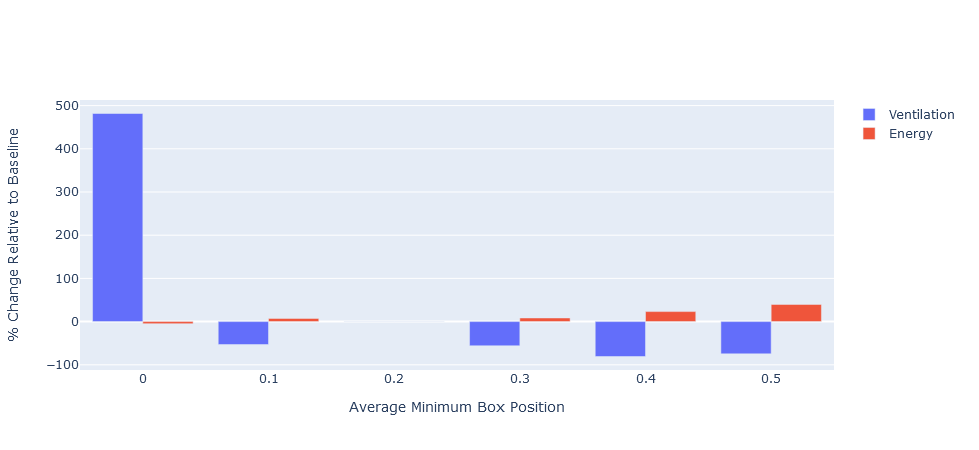

In [10]:
data=average_outputs_design.copy(deep=True)
data.loc[:,'Energy [ekWh/m2]':]=(data.loc[:,'Energy [ekWh/m2]':]-data.loc[2,'Energy [ekWh/m2]':])/data.loc[2,'Energy [ekWh/m2]':]*100

fig = go.Figure([go.Bar(x=data['Average Minimum Box Position'],
                        y=data['Underventilation [%] 1.0'],
                        name='Ventilation'
                       ),
                go.Bar(x=data['Average Minimum Box Position'],
                        y=data['Energy [ekWh/m2]'],
                        name='Energy')],
               layout={
        'yaxis': {'title': '% Change Relative to Baseline',},
        'xaxis': {'title': 'Average Minimum Box Position'}
    })
fig.update_layout(showlegend=True)
fig.show()

In [11]:
average_outputs_design['Underventilation [%] 1.0'].describe()

count     6.000000
mean      3.824326
std       6.181796
min       0.539009
25%       0.842134
50%       1.275578
75%       2.435002
max      16.336663
Name: Underventilation [%] 1.0, dtype: float64

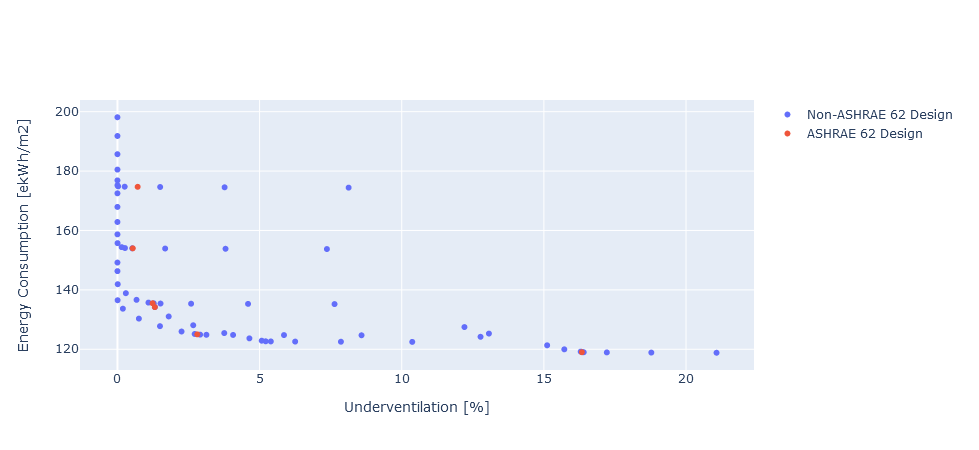

In [12]:
customdata1 = np.stack((average_outputs['Average Minimum Box Position'], average_outputs['Minimum OA Damper Percent Open'],average_outputs['Underventilation [%] 1.0']/100)
                       , axis=-1)
customdata2 = np.stack((average_outputs_design['Average Minimum Box Position'], average_outputs_design['Minimum OA Damper Percent Open'],average_outputs_design['Underventilation [%] 1.0']/100)
                       , axis=-1)
fig = go.Figure([go.Scatter(x=average_outputs['Underventilation [%] 1.0'],
                           y=average_outputs['Energy [ekWh/m2]'],
                           mode='markers',
                           name='Non-ASHRAE 62 Design',
                        customdata=customdata1,
                           hovertemplate=
                                "Average Minimum Box Position: %{customdata[0]:.0%}<br>" +
                                "Minimum OA Damper Percent Open: %{customdata[1]:.0%}<br>" +
                                "Underventilation: %{customdata[2]:.2%}<br>" +
                                "Energy: %{y:.1f} ekWh/m2" +
                                "<extra></extra>",),
                 go.Scatter(x=average_outputs_design['Underventilation [%] 1.0'],
                           y=average_outputs_design['Energy [ekWh/m2]'],
                           mode='markers',
                           name='ASHRAE 62 Design',
                 customdata=customdata2,
                           hovertemplate=
                                "Average Minimum Box Position: %{customdata[0]:.0%}<br>" +
                                "Minimum OA Damper Percent Open: %{customdata[1]:.0%}<br>" +
                                "Underventilation: %{customdata[2]:.2%}<br>" +
                                "Energy: %{y:.1f} ekWh/m2" +
                                "<extra></extra>",)
                ])

fig.update_layout(
                {'yaxis': {'title':'Energy Consumption [ekWh/m2]'},
                'xaxis': {'title':'Underventilation [%]'}
                })

fig.update_layout(
    hoverlabel=dict(
        bgcolor="white",
        font_size=16,
        font_family="Rockwell"
    )
)

fig.show()

## Part 2
Does increasing the degree-of-freedom beyond a single minimum box position to a zone-by-zone level design provide significant improvements in performance?

- Compare the pareto-front to the baseline number
- Compare the pareto-front to an 'average box position' pareto-front in terms of performance
- Is it possible to prove statistical significance based on standard deviation?
- R2 value for each parameter vs. each objective. Statistically significant difference R2 values?
- Compare the average box position at pareto-front with locked vs. independent and quantify performance difference

In [13]:
nondominated = pareto.eps_sort([list(opt_outputs.itertuples(False))], [16,17], None)
nondominated=pd.DataFrame(nondominated,columns=opt_outputs.columns)

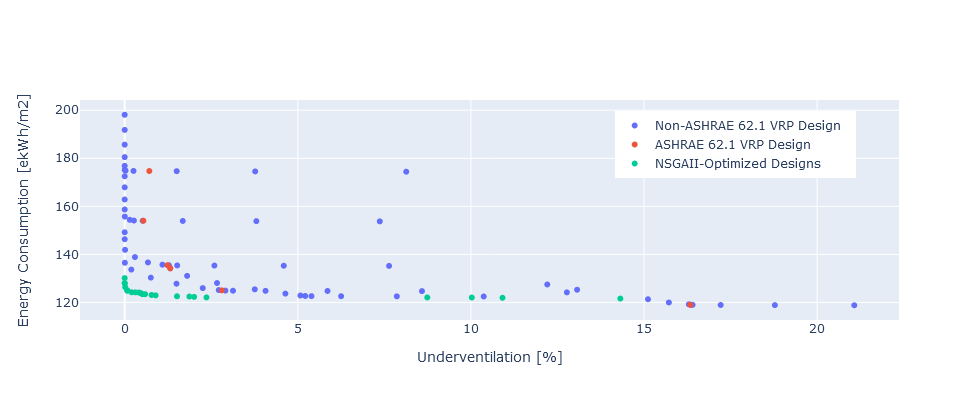

In [19]:
customdata1 = np.stack((average_outputs['Average Minimum Box Position'], average_outputs['Minimum OA Damper Percent Open'],average_outputs['Underventilation [%] 1.0']/100)
                       , axis=-1)
customdata2 = np.stack((average_outputs_design['Average Minimum Box Position'], average_outputs_design['Minimum OA Damper Percent Open'],average_outputs_design['Underventilation [%] 1.0']/100)
                       , axis=-1)
customdata3 = np.stack((nondominated['Average Minimum Box Position'], nondominated['Minimum OA Damper Percent Open'],nondominated['Underventilation [%] 1.0']/100)
                       , axis=-1)
customdata4 = np.stack((average_opt_outputs['Average Minimum Box Position'], average_opt_outputs['Minimum OA Damper Percent Open'],average_opt_outputs['Underventilation [%] 1.0']/100)
                       , axis=-1)
fig = go.Figure([
    go.Scatter(x=average_outputs['Underventilation [%] 1.0'],
                           y=average_outputs['Energy [ekWh/m2]'],
                           mode='markers',
                           name='Non-ASHRAE 62.1 VRP Design',
                        customdata=customdata1,
                           hovertemplate=
                                "Average Minimum Box Position: %{customdata[0]:.0%}<br>" +
                                "Minimum OA Damper Percent Open: %{customdata[1]:.0%}<br>" +
                                "Underventilation: %{customdata[2]:.2%}<br>" +
                                "Energy: %{y:.1f} ekWh/m2" +
                                "<extra></extra>",),
                 go.Scatter(x=average_outputs_design['Underventilation [%] 1.0'],
                           y=average_outputs_design['Energy [ekWh/m2]'],
                           mode='markers',
                           name='ASHRAE 62.1 VRP Design',
                 customdata=customdata2,
                           hovertemplate=
                                "Average Minimum Box Position: %{customdata[0]:.0%}<br>" +
                                "Minimum OA Damper Percent Open: %{customdata[1]:.0%}<br>" +
                                "Underventilation: %{customdata[2]:.2%}<br>" +
                                "Energy: %{y:.1f} ekWh/m2" +
                                "<extra></extra>",),
                 go.Scatter(x=nondominated['Underventilation [%] 1.0'],
                           y=nondominated['Energy [ekWh/m2]'],
                           mode='markers',
                           name='NSGAII-Optimized Designs',
                 customdata=customdata3,
                           hovertemplate=
                                "Average Minimum Box Position: %{customdata[0]:.0%}<br>" +
                                "Minimum OA Damper Percent Open: %{customdata[1]:.0%}<br>" +
                                "Underventilation: %{customdata[2]:.2%}<br>" +
                                "Energy: %{y:.1f} ekWh/m2" +
                                "<extra></extra>",)
#                  go.Scatter(x=average_opt_outputs['Underventilation [%] 1.0'],
#                            y=average_opt_outputs['Energy [ekWh/m2]'],
#                            mode='markers',
#                            name='Optimized Designs with 1 DOF Minimum Box Position',
#                  customdata=customdata4,
#                            hovertemplate=
#                                 "Average Minimum Box Position: %{customdata[0]:.0%}<br>" +
#                                 "Minimum OA Damper Percent Open: %{customdata[1]:.0%}<br>" +
#                                 "Underventilation: %{customdata[2]:.2%}<br>" +
#                                 "Energy: %{y:.1f} ekWh/m2" +
#                                 "<extra></extra>",)
                ])

fig.update_layout(
                {'yaxis': {'title':'Energy Consumption [ekWh/m2]'},
                'xaxis': {'title':'Underventilation [%]'}
                })

fig.update_layout(
    hoverlabel=dict(
        bgcolor="white",
        font_size=16,
        font_family="Rockwell"
    ),
    width=800,
    height=400
)


fig.update_layout(legend=dict(
    yanchor="top",
    y=0.95,
    xanchor="center",
    x=0.8,
    orientation='v'
))

fig.show()
fig.write_html("tradeoff.html", include_plotlyjs=True)
fig.write_json("tradeoff.json")

In [15]:
savings=average_opt_outputs.sort_values('Average Minimum Box Position')-nondominated.sort_values('Average Minimum Box Position')
savings['Energy Savings'] = [1 if x > 0 else 0 for x in savings['Energy [ekWh/m2]']]
savings['Ventilation Savings'] = [1 if x > 0 else 0 for x in savings['Underventilation [%] 1.0']]
savings['Total Improvement']=savings['Energy Savings']*savings['Ventilation Savings']
savings.drop('Energy Savings',axis=1,inplace=True)
savings.drop('Ventilation Savings',axis=1,inplace=True)
savings_stats=savings.describe()

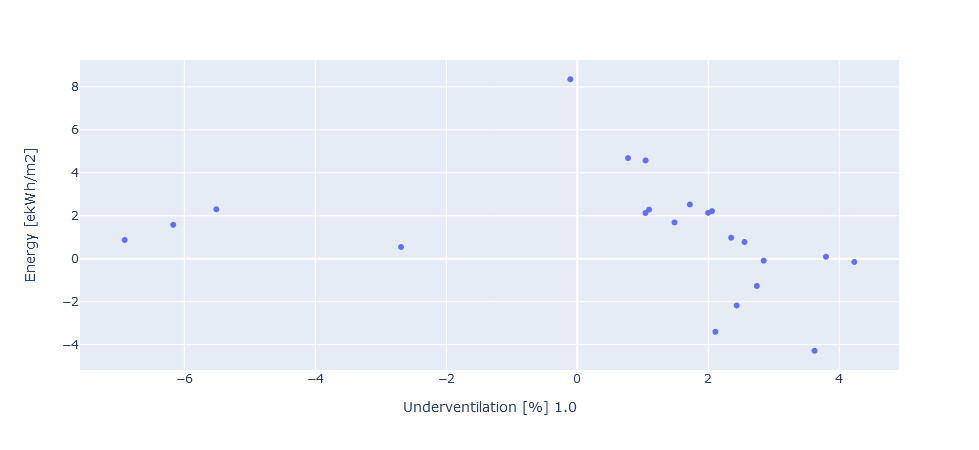

In [16]:
# px.histogram(savings,x=['Energy [ekWh/m2]','Underventilation [%] 1.0'])
px.scatter(savings,x='Underventilation [%] 1.0',y='Energy [ekWh/m2]')

In [17]:
# 95% Confidence interval on energy savings from increasing DOF
objective='Energy [ekWh/m2]'
# objective='Underventilation [%] 1.0'
print(savings_stats[objective]['mean']+1.96*savings_stats[objective]['std']/np.sqrt(savings_stats[objective]['count']))
print(savings_stats[objective]['mean']-1.96*savings_stats[objective]['std']/np.sqrt(savings_stats[objective]['count']))

2.338027454889451
0.058686103449405946


In [18]:
# 95% Confidence interval that allowing the expanded DOF will improve both underventilation and energy
print(savings_stats['Total Improvement']['mean']+1.96*np.sqrt((savings_stats['Total Improvement']['mean']*(1-savings_stats['Total Improvement']['mean']))/savings_stats['Total Improvement']['count']))
print(savings_stats['Total Improvement']['mean']-1.96*np.sqrt((savings_stats['Total Improvement']['mean']*(1-savings_stats['Total Improvement']['mean']))/savings_stats['Total Improvement']['count']))

0.7089367020284982
0.29106329797150177
